In [1]:
import os, gc
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold, GroupKFold

import timm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from time import time, ctime

from engine_hms_trainer import (
    seed_everything, calc_entropy, evaluate_oof, get_logger, TARGETS, TARGETS_PRED, Trainer
)
from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr

from pyts.approximation import PiecewiseAggregateApproximation
from pyts.preprocessing import MinMaxScaler
from pyts.image import GramianAngularField


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

EEG_FEAT_ALL = [
    'Fp1', 'F3', 'C3', 'P3', 
    'F7', 'T3', 'T5', 'O1', 
    'Fz', 'Cz', 'Pz', 'Fp2', 
    'F4', 'C4', 'P4', 'F8', 
    'T4', 'T6', 'O2', 'EKG'
    ]

EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}

seed_everything(ModelConfig.SEED)


Output Dir:  ./outputs/


# Load Data

In [ ]:
def eeg_from_parquet(parquet_path: str, use_feature=EEG_FEAT_USE, display: bool = False) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract full length EEG Sequence ===
    # fill missing values with mean
    # first fill missing values with mean of each column
    # then if all values are missing, fill with 0
    eeg = pd.read_parquet(parquet_path, columns=use_feature)
    eeg = eeg.fillna(eeg.mean(skipna=True)).fillna(0)
    data = eeg.values.astype(np.float32)

    if display:
        fig, ax = plt.subplots(len(use_feature), 1, figsize=(15, 3*len(use_feature)), sharex=True)
        
        for i, feat in enumerate(use_feature):
            ax[i].plot(data[:, i], label=feat)
            ax[i].legend()
            ax[i].grid()
       
        name = parquet_path.split('/')[-1].split('.')[0]
        ax[0].set_title(f'EEG {name}',size=16)
        plt.show()    
    return data


In [ ]:
CREATE_EEGS = True
ALL_EEG_SIGNALS = {}
eeg_paths = list(Path(PATHS.TRAIN_EEGS).glob('*.parquet'))
preload_eegs_path = Path('./inputs/eegs_full.npy')

if CREATE_EEGS:
    count = 0
    for parquet_path in tqdm(eeg_paths, total=len(eeg_paths)):
        eeg_id = int(parquet_path.stem)
        eeg_path = str(parquet_path)
        data = eeg_from_parquet(eeg_path, display=count<1)
        ALL_EEG_SIGNALS[eeg_id] = data
        count += 1
    np.save("./inputs/eegs_full.npy", ALL_EEG_SIGNALS)
else:
    ALL_EEG_SIGNALS = np.load(preload_eegs_path, allow_pickle=True).item()

In [ ]:
def get_non_overlap(train_csv, targets):

    df = train_csv.groupby(['eeg_id'] + targets).agg({
            'spectrogram_id': 'first',
            'spectrogram_label_offset_seconds': ['min', 'max'],
            'eeg_label_offset_seconds': ['min', 'max'],
            'patient_id': 'first',
            'expert_consensus': 'first',
            'total_votes': 'sum',
            'entropy': 'mean',
            'is_hard': 'mean'
        }).reset_index()

    df.columns = ["eeg_id"] + targets + \
        ['spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'patient_id', 'target', 'total_votes', 'average_entropy', 'is_hard']

    df[targets] = df[targets].apply(lambda x: x / x.sum(), axis=1)

    return df


In [ ]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

print("targets: ", targets)

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)
train_csv['is_hard'] = (train_csv['entropy'] < 5.5).astype(int)

train_all = get_non_overlap(train_csv, targets)
train_hard = get_non_overlap(train_csv[train_csv['is_hard'] == 1].copy().reset_index(), targets)

print("train_all: ", train_all.shape)
print("hard samples: ", train_hard.shape)

train_all.head(15)

In [ ]:
unique_eeg = train_all.groupby('eeg_id').size().to_frame().reset_index()
unique_eeg.columns = ['eeg_id', 'count']

df_focus = train_all[train_all['eeg_id'].isin(unique_eeg[unique_eeg['count'] > 1]['eeg_id'])].copy()
df_focus = df_focus.reset_index(drop=True)
df_focus

In [ ]:
ModelConfig.MODEL_BACKBONE = 'tf_efficientnet_b2'
ModelConfig.MODEL_NAME = "GAF_ENet_B2_Small_Fix_EEG"
ModelConfig.BATCH_SIZE = 8
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
ModelConfig.EPOCHS = 6
ModelConfig.DROP_RATE = 0.1
ModelConfig.EARLY_STOP_ROUNDS = 5

logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

# Dataset

In [ ]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x #quantized

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [ ]:
class EEGSeqDataset(Dataset):
    def __init__(self, df, config, eegs, mode='train', verbose=False):
        self.df = df
        self.mode = mode
        self.eegs = eegs
        self.verbose = verbose
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        X, y_prob = self.__data_generation(idx)
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_prob, dtype=torch.float32)
    
    def __data_generation(self, index):
        row = self.df.iloc[index]

        if self.verbose:
            print(f"Row {index}", row[['eeg_id', 'eeg_off_min', 'eeg_off_max', 'target']].tolist())

        X = np.zeros((10_000, 8), dtype='float32')
        
        start_sec = int((row['eeg_off_min'] + row['eeg_off_max']) // 2)
        data = self.eegs[row.eeg_id][start_sec*200 : (start_sec+50)*200]

        # === Feature engineering ===
        X[:,0] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
        X[:,1] = data[:,EEF_FEAT_INDEX['T3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,2] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['C3']]
        X[:,3] = data[:,EEF_FEAT_INDEX['C3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,4] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['C4']]
        X[:,5] = data[:,EEF_FEAT_INDEX['C4']] - data[:,EEF_FEAT_INDEX['O2']]

        X[:,6] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['T4']]
        X[:,7] = data[:,EEF_FEAT_INDEX['T4']] - data[:,EEF_FEAT_INDEX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        # !!! change to bandpass filter (low=0.5, hight=20, order=2) !!!
        # X = butter_lowpass_filter(X)
        X = butter_bandpass_filter(X, .5, 20, 200, order=2)

        if self.mode != 'test':
            y_prob = row[TARGETS].values.astype(np.float32)
        else:
            y_prob = np.zeros(6, dtype='float32')

        return X, y_prob

def collate_gaf_image(batch):
    # Assuming `batch` is a list of tuples (X, y) where X is the time series and y is the label
    # Initialize GASF and GADF
    gasf = GramianAngularField(image_size=50, method='summation')
    gadf = GramianAngularField(image_size=50, method='difference')
    chunk_starts = [0, 2000, 4000, 6000, 8000]
    chunk_len = 2000
    ts_len, n_channels = batch[0][0].shape
    
    transformed_x = []
    for sample_id, (X, y) in enumerate(batch):
        channel_images = []
        for channel_id in range(n_channels):
            chunk_images = []
            for t_start in chunk_starts:
                t_end = t_start + 2000
                x_ts = X[t_start:t_end, channel_id].reshape(1, -1)
                x_gasf = gasf.transform(x_ts)
                x_gadf = gadf.transform(x_ts)
                # Concatenate GASF, GADF, and a zero matrix along the vertical axis
                gaf_combined = np.concatenate([x_gasf, x_gadf], axis=0)
                chunk_images.append(gaf_combined)
            # Concatenate all chunks for this channel along the horizontal axis
            chunk_full = np.concatenate(chunk_images, axis=2)
            channel_images.append(chunk_full)
            
        sample_image = np.concatenate(channel_images, axis=1)
        c, h, w = sample_image.shape
        sample_image = np.concatenate([sample_image, np.zeros((1, h, w))], axis=0)
        sample_image = np.nan_to_num(sample_image, nan=0.0)
        transformed_x.append(sample_image)
    
    # Convert to PyTorch tensors
    x_tensor = torch.tensor(np.array(transformed_x), dtype=torch.float32)
    y_tensor = torch.stack([item[1] for item in batch])
    return x_tensor, y_tensor

In [ ]:
train_dataset = EEGSeqDataset(df_focus, ModelConfig, ALL_EEG_SIGNALS, mode="train", verbose=True)

batches = [train_dataset[i] for i in range(7, 11)]
x_gaf, y_gaf = collate_gaf_image(batches) # -> (batch_size, n_channels, h, w)
print(x_gaf.shape, y_gaf.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 10))
x_gaf_array = x_gaf.detach().to('cpu').numpy()
for item in range(4):
    ax = axes.flatten()[item]
    img = x_gaf_array[item]
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(", ".join([f"{v:.2f}" for t, v in zip(TARGETS, y_gaf[item].tolist())]))

fig.tight_layout()
plt.show()

In [ ]:
# visualize the dataset
train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train", verbose=False)
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False, collate_fn=collate_gaf_image)

fig, axes = plt.subplots(1, 4, figsize=(20, 10))
for batch in train_loader:
    X, y = batch
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    for item in range(4):
        ax = axes.flatten()[item]
        img = X.detach().to('cpu').numpy()[item]
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set_title(", ".join([f"{v:.2f}" for t, v in zip(TARGETS, y[item].tolist())]))
    break

fig.tight_layout()
plt.show()

# Model

In [ ]:
class GAF_EfficientNet(nn.Module):

    def __init__(self, config, num_classes: int = 6, pretrained: bool = True):
        super(GAF_EfficientNet, self).__init__()
        
        self.config = config

        self.model = timm.create_model(
            config.MODEL_BACKBONE,
            pretrained=pretrained,
            drop_rate=config.DROP_RATE,
            drop_path_rate=config.DROP_PATH_RATE,
        )

        self.features = nn.Sequential(*list(self.model.children())[:-2])
        
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.model.num_features, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.custom_layers(x)
        return x

In [ ]:
train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False, collate_fn=collate_gaf_image)

model = GAF_EfficientNet( ModelConfig, num_classes=6 )

for i, batch in enumerate(train_loader):
    X, y = batch
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    y_pred = model(X)
    print(y_pred.shape)
    break 


In [ ]:
# feature_id = 0
# feat = rnn_out.detach().cpu().numpy()
# print(feat[0].mean(axis=0).shape)

# fig, ax = plt.subplots(2, 1, figsize=(20, 5))
# # for i in range(0, feat.shape[1], 16):
# #     ax[0].plot(feat[:, i].detach().cpu().numpy())
# ax[0].plot(feat[0, -1, :])
# ax[0].plot(feat[0].mean(axis=0))
# ax[1].plot(resnet_out[0].detach().cpu().numpy())

# plt.title(f"Feature {feature_id}")
# plt.show()

# Train

In [ ]:
def prepare_k_fold(df, k_folds=5):

    kf = KFold(n_splits=k_folds)
    unique_spec_id = df['spectrogram_id'].unique()
    df['fold'] = k_folds

    for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df


def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = EEGSeqDataset(train_folds, ModelConfig, ALL_EEG_SIGNALS, mode="train")
    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=collate_gaf_image, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=collate_gaf_image, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

In [ ]:
k_folds = 5
train_all = prepare_k_fold(train_all, k_folds=k_folds)

# gkf = GroupKFold(n_splits=k_folds)
# for fold, (train_index, valid_index) in enumerate(gkf.split(train_all, train_all.target, train_all.patient_id)):
#     train_all.loc[valid_index, "fold"] = int(fold)


# for fold in range(k_folds):
#     print(f"Fold {fold} = {len(train_all[train_all['fold'] == fold])}")

In [ ]:
# Major Train Loop

# ================== Logger ==================

logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

# ================== Run Training ==================

oof_stage_1 = pd.DataFrame()
loss_history_1 = []

logger.info(f"{'=' * 100}\nStage 1: Train ResNetGRU\n{'=' * 100}")
for fold in range(k_folds):
    tik = time()

    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    model = GAF_EfficientNet( ModelConfig, num_classes=6 )
    
    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    logger.info(f"{'=' * 100}\nFold: {fold} || Valid: {valid_folds.shape[0]}; \n{'=' * 100}")
    logger.info(f"- Train: {train_folds.shape[0]}; Epoch = {ModelConfig.EPOCHS}; Dropout = {ModelConfig.RESNET_GRU_DROPOUT} -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_1):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
## STAGE 2
oof_stage_2 = pd.DataFrame()
loss_history_2 = []

logger.info(f"{'=' * 100}\nStage 2: Train ResNetGRU\n{'=' * 100}")
for fold in range(k_folds):
    tik = time()
    
    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)

    logger.info(f"- Hard: {train_folds.shape[0]}; Epoch: {ModelConfig.EPOCHS}; Dropout: {ModelConfig.RESNET_GRU_DROPOUT} -")
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = GAF_EfficientNet( ModelConfig, num_classes=6 )

    valid_predicts, loss_records = train_fold(
        model, fold, train_hard, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_2):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
plt.show()

In [2]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

CSV Path:  ./outputs/EEGSeq_Wavenet_oof_1.csv
Kaggle Score:  0.698323584970098
Average KL Loss:  0.6983236


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,...,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,568657,0.0,0.000000,0.25,0.000000,0.166667,0.583333,789577333,0.0,16.0,...,0,0.496760,0.026554,0.089381,0.036005,0.116614,0.234686,0,5,0.847791
1,582999,0.0,0.857143,0.00,0.071429,0.000000,0.071429,1552638400,0.0,38.0,...,0,0.190734,0.229549,0.000926,0.143735,0.025093,0.409963,5,1,0.954513
2,642382,0.0,0.000000,0.00,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,...,0,0.045450,0.006140,0.000964,0.040185,0.125593,0.781668,5,5,0.246326
3,751790,0.0,0.000000,1.00,0.000000,0.000000,0.000000,618728447,908.0,908.0,...,0,0.006517,0.052318,0.930521,0.000178,0.000269,0.010196,2,2,0.072010
4,778705,0.0,0.000000,0.00,0.000000,0.000000,1.000000,52296320,0.0,0.0,...,0,0.364543,0.032701,0.015350,0.077955,0.125363,0.384089,5,5,0.956882


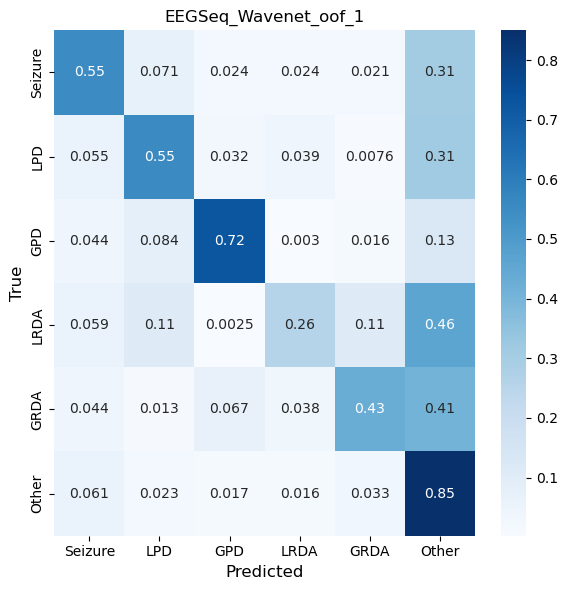

In [4]:
csv_path = f'./outputs/EEGSeq_Wavenet_oof_1.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

In [ ]:
csv_path = f'./outputs/ResNetGRU/ResNetGRU_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()